In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp

# Шаг 1: Загружаем данные

In [17]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN']
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

C:\Users\pluso\AppData\Local\Temp\ipykernel_3340\1298712397.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  4 of 4 completed


In [19]:
data.head(3)

Price           Close                                         High             \
Ticker           AAPL       AMZN        MSFT       TSLA       AAPL       AMZN   
Date                                                                            
2020-01-02  72.620834  94.900497  153.042297  28.684000  72.681281  94.900497   
2020-01-03  71.914803  93.748497  151.136688  29.534000  72.676431  94.309998   
2020-01-06  72.487846  95.143997  151.527298  30.102667  72.526533  95.184502   

Price                                    Low                         \
Ticker            MSFT       TSLA       AAPL       AMZN        MSFT   
Date                                                                  
2020-01-02  153.147108  28.713333  71.373211  93.207497  150.860341   
2020-01-03  152.403944  30.266666  71.689942  93.224998  150.603110   
2020-01-06  151.594002  30.104000  70.783248  93.000000  149.126182   

Price                       Open                                       Volume  \
Ticker           TSLA       AAPL       AMZN        MSFT       TSLA       AAPL   
Date                                                                            
2020-01-02  28.114000  71.627084  93.750000  151.289108  28.299999  135480400   
2020-01-03  29.128000  71.847102  93.224998  150.850853  29.366667  146322800   
2020-01-06  29.333332  71.034709  93.000000  149.669298  29.364668  118387200   

Price                                      
Ticker          AMZN      MSFT       TSLA  
Date                                       
2020-01-02  80580000  22622100  142981500  
2020-01-03  75288000  21116200  266677500  
2020-01-06  81236000  20813700  151995000

In [10]:
data_close = data['Close']
data_close

Ticker,AAPL,AMZN,MSFT,TSLA
Date,,,,
2020-01-02,72.620834,94.900497,153.042297,28.684000
2020-01-03,71.914803,93.748497,151.136688,29.534000
2020-01-06,72.487846,95.143997,151.527298,30.102667
2020-01-07,72.146950,95.343002,150.145706,31.270666
2020-01-08,73.307518,94.598503,152.537277,32.809334
...,...,...,...,...
2024-12-23,254.655716,225.059998,433.583038,430.600006
2024-12-24,257.578674,229.050003,437.647369,462.279999
2024-12-26,258.396667,227.050003,436.432068,454.130005


In [13]:
returns = data_close.pct_change().dropna()
returns

Ticker,AAPL,AMZN,MSFT,TSLA
Date,,,,
2020-01-03,-0.009722,-0.012139,-0.012452,0.029633
2020-01-06,0.007968,0.014886,0.002584,0.019255
2020-01-07,-0.004703,0.002092,-0.009118,0.038801
2020-01-08,0.016086,-0.007809,0.015928,0.049205
2020-01-09,0.021241,0.004799,0.012493,-0.021945
...,...,...,...,...
2024-12-23,0.003065,0.000622,-0.003092,0.022657
2024-12-24,0.011478,0.017729,0.009374,0.073572
2024-12-26,0.003176,-0.008732,-0.002777,-0.017630


# 2. Вычисление статистик

In [28]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [29]:
mean_returns

Ticker
AAPL    0.001189
AMZN    0.000931
MSFT    0.000995
TSLA    0.003026
dtype: float64

In [30]:
cov_matrix

Ticker,AAPL,AMZN,MSFT,TSLA
Ticker,,,,
AAPL,0.000398,0.000268,0.000287,0.000408
AMZN,0.000268,0.000514,0.000295,0.000415
MSFT,0.000287,0.000295,0.000369,0.000363
TSLA,0.000408,0.000415,0.000363,0.001791


# 3. Симуляция случайных портфелей

In [34]:
n_portfolios = 50000
results = np.zeros((3, n_portfolios))

In [35]:
for i in range(n_portfolios):
    weights = np.random.rand(len(tickers))
    weights /= np.sum(weights)
    
    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_std
    
    results[0, i] = port_return
    results[1, i] = port_std
    results[2, i] = sharpe

# 4. Визуализация

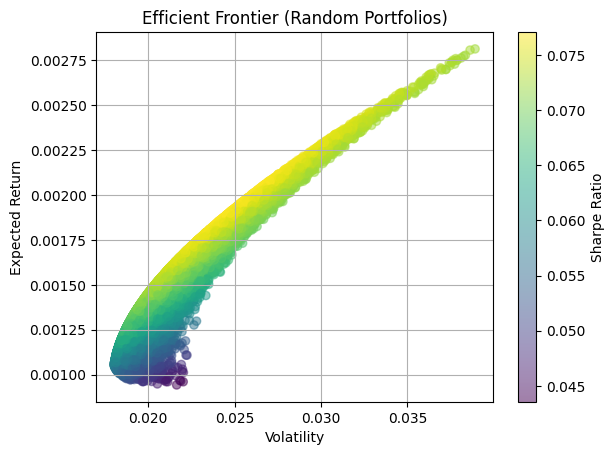

In [36]:
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o', alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier (Random Portfolios)')
plt.grid(True)
plt.show()

# 5. Оптимальный портфель при заданной доходности

In [58]:
def optimizer_function(cov_matrix, ret_target):
    n = len(cov_matrix)
    w = cp.Variable(n)

    objective = cp.Minimize(cp.quad_form(w, cov_matrix.values))
    constraints = [cp.sum(w) == 1,
                   mean_returns.values @ w >= ret_target,
                   w >= 0]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w

In [67]:
w = optimizer_function(cov_matrix, 0.001)

# Zip and format
output = ", ".join(f"{ticker}:{weight:.2f}" for ticker, weight in zip(tickers, w.value))
print(f"Optimized weights: {output}")

Optimized weights: AAPL:0.37, MSFT:0.18, TSLA:0.44, AMZN:0.00


In [63]:
w = optimizer_function(cov_matrix, 0.002)

# Zip and format
output = ", ".join(f"{ticker}:{weight:.2f}" for ticker, weight in zip(tickers, w.value))
print(f"Optimized weights: {output}")

Optimized weights: AAPL:0.47, MSFT:0.00, TSLA:0.08, AMZN:0.45


In [64]:
w = optimizer_function(cov_matrix, 0.003)

# Zip and format
output = ", ".join(f"{ticker}:{weight:.2f}" for ticker, weight in zip(tickers, w.value))
print(f"Optimized weights: {output}")

Optimized weights: AAPL:0.01, MSFT:-0.00, TSLA:-0.00, AMZN:0.99
